In [1]:
import qiskit 
print(qiskit.__version__)

1.3.1


### Max Cut

In [46]:
# basic imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# quantum imports
from qiskit_optimization.applications import Maxcut
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import QAOAAnsatz
# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### Generate a Random Graph

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



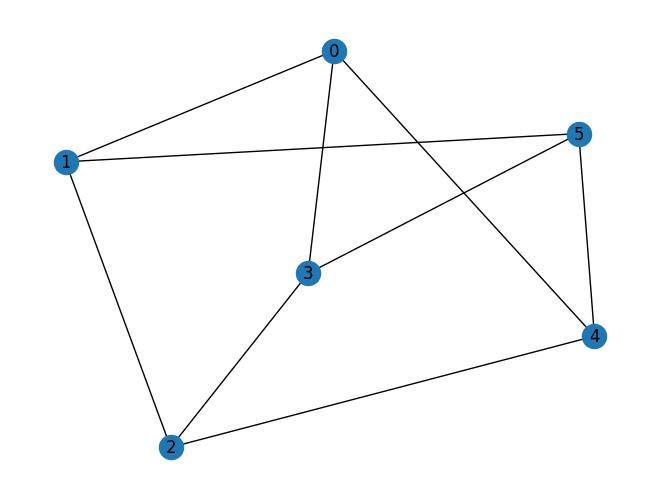

In [12]:
seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))
# Assign random weights to the edges

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

### Exact Solution

In [4]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(problem)
print(result.prettyprint())

objective function value: 9.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


In [5]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Minimize
 obj: - 3 x_0 - 3 x_1 - 3 x_2 - 3 x_3 - 3 x_4 - 3 x_5 + [ 4 x_0*x_1 + 4 x_0*x_3
      + 4 x_0*x_4 + 4 x_1*x_2 + 4 x_1*x_5 + 4 x_2*x_3 + 4 x_2*x_4 + 4 x_3*x_5
      + 4 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [6]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -4.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIZIIZ', 'IZIIIZ', 'IIIZZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


### QAOA

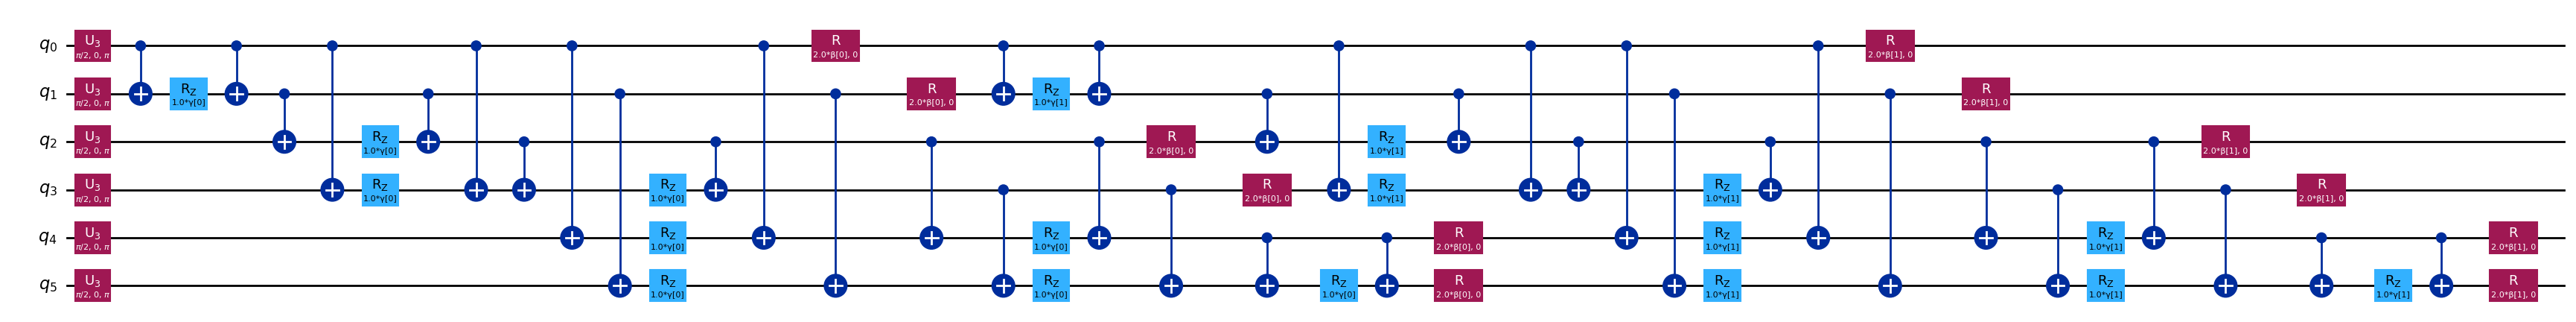

In [35]:


circuit = QAOAAnsatz(cost_operator=qubitOp, reps=2)
#circuit.measure_all()
circuit = circuit.decompose(reps=3)
circuit.draw('mpl',fold=-1)

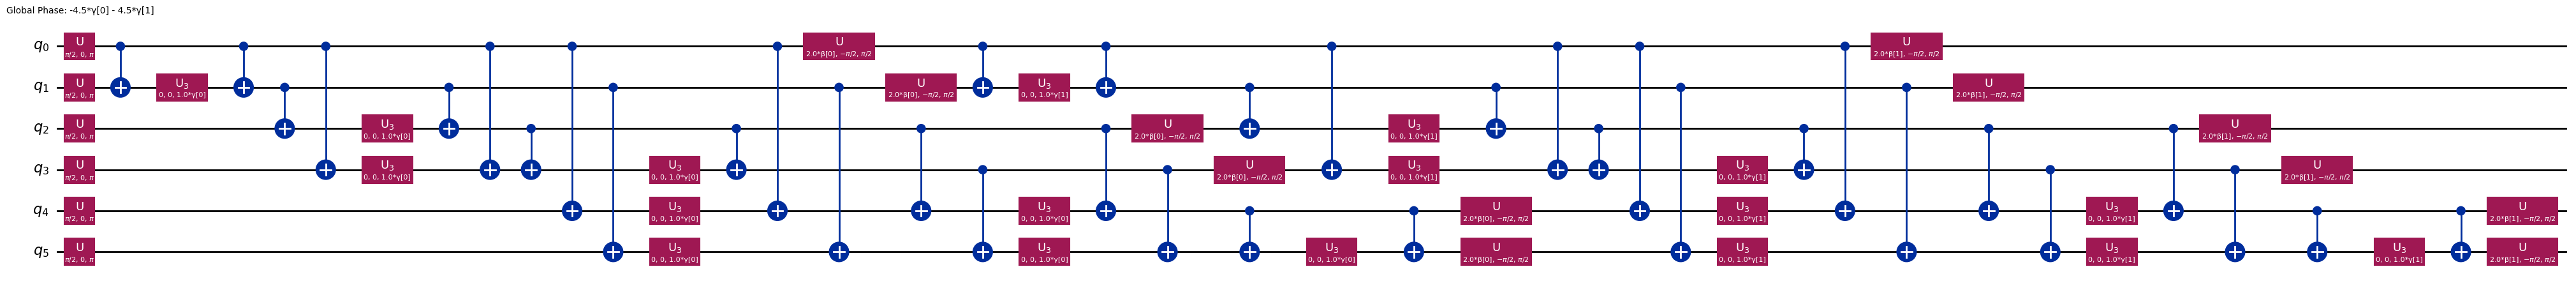

In [36]:
circuit.decompose(reps=2).draw('mpl',fold=-1)

### Execute

In [37]:
initial_gamma = np.pi
initial_beta = np.pi/2
reps = 2
init_params = [initial_gamma, initial_beta]*reps
print(init_params)

[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [38]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [39]:
objective_func_vals = [] # Store the objective function values

result_unweighted = minimize(
    cost_func_estimator,
    init_params,
    args= (circuit, qubitOp, estimator),
    method="COBYLA",
    tol=1e-3
)
print(result_unweighted)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.997802734375
       x: [ 2.041e+00  6.589e-01  2.481e+00  2.946e-01]
    nfev: 45
   maxcv: 0.0


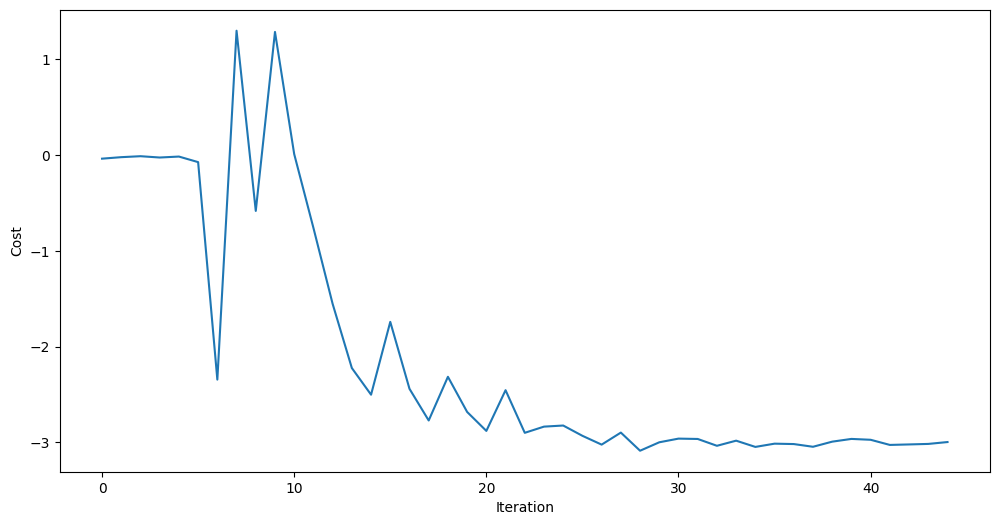

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

### Post Processing

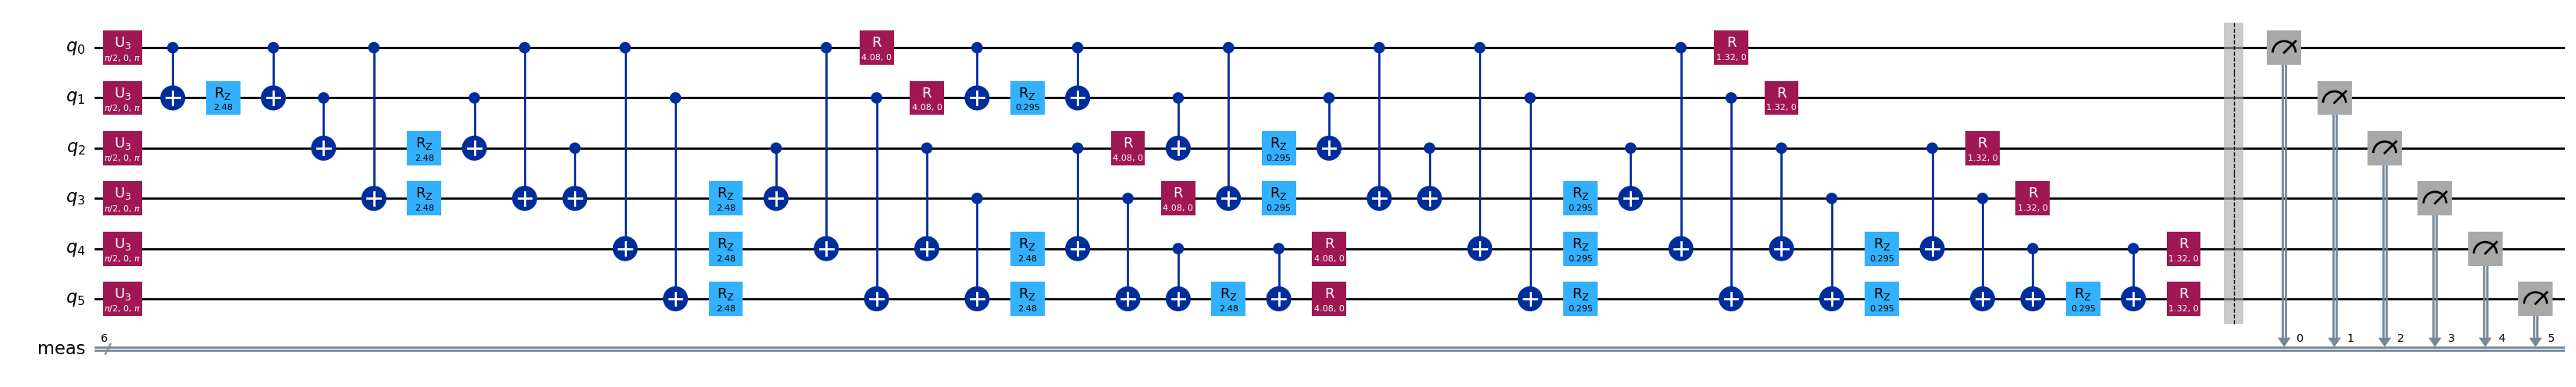

In [41]:
optimized_circuit = circuit.assign_parameters(result_unweighted.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', idle_wires=False,fold=-1)

In [42]:
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [44]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 1, 0]


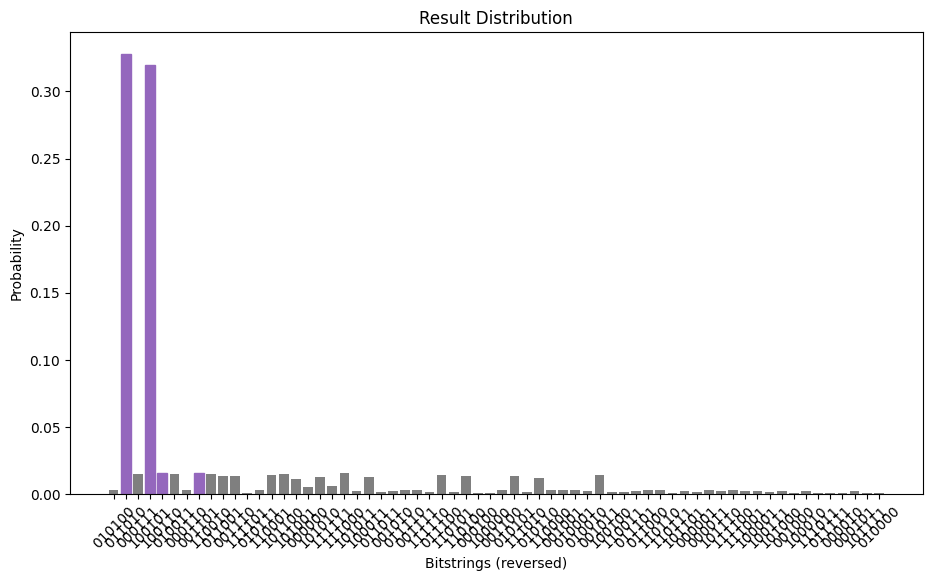

In [47]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin  # Assuming final_distribution_bin is defined elsewhere
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.extend(np.where(values == value)[0].tolist())  # Extract as a list to get individual elements

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")

# Ensure each position is an integer index for setting color
for p in positions:
    ax.get_children()[p].set_color("tab:purple")

plt.show()